# Hinton's Capsule Network

In [1]:
# import resources
import numpy as np
import torch

# random seed (for reproducibility)
seed = 1

# set random seed for pytorch
torch.manual_seed(seed)

# set random seed for numpy
np.random.seed(seed)

In [2]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


## Obtain the [Data](https://pytorch.org/docs/stable/torchvision/datasets.html)

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

In [4]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# convert data to Tensors
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False, 
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

#### Visualizing Training Data

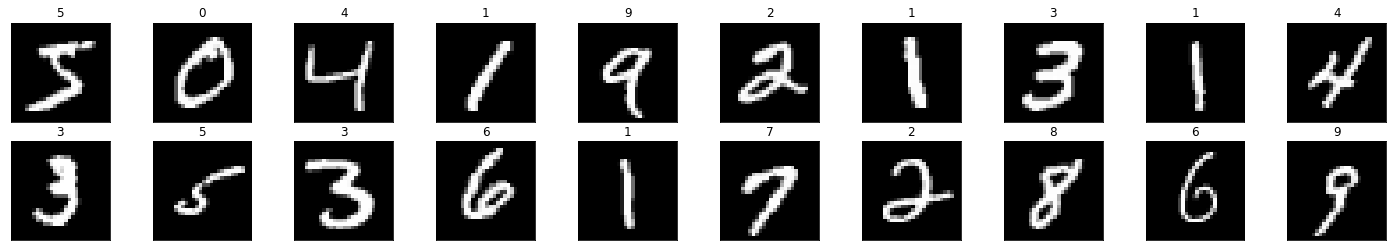

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Capsulate Architecture

<img src='images/capsule-architecture.png' width="75%"/>

## Encoder

## First Layer: Convolutional Layer

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=256):
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # applying a ReLu activation to the outputs of the conv layer
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 20, 20, 256)
        
        return features

## Second Layer: Primary Capsules

In [8]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
        '''Constructs a list of convolutional layers to be used in 
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        
        return output_tensor
    
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
        
        # stack up output vectors, u, one for each capsule
        u = torch.cat(u, dim=-1)
        
        # squashing the stack of vectors
        u_squash = self.squash(u)
        
        return u_squash

## Third Layer: Digit Capsules

In [9]:
def softmax(input_tensor, dim=1):
    # transpose input
    transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
    
    # calculate softmax
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    
    # un-transpose result
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)

In [10]:
# dynamic routing
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''    
    
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        c_ij = softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j

In [11]:
class DigitCaps(nn.Module):
    
    def __init__(self, num_capsules=10, previous_layer_nodes=32*6*6, 
                 in_channels=8, out_channels=16):
        '''Constructs an initial weight matrix, W, and sets class variables.
           param num_capsules: number of capsules to create
           param previous_layer_nodes: dimension of input capsule vector, default value = 1152
           param in_channels: number of capsules in previous layer, default value = 8
           param out_channels: dimensions of output capsule vector, default value = 16
           '''
        super(DigitCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and DigitCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, 
                                          in_channels, out_channels))

    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        
        return output_tensor
    
    def forward(self, u):
        '''Defines the feedforward behavior.
           param u: the input; vectors from the previous PrimaryCaps layer
           return: a set of normalized, capsule output vectors
           '''
        
        # adding batch_size dims and stacking all u vectors
        u = u[None, :, :, None, :]
        
        # 4D weight matrix
        W = self.W[:, None, :, :, :]
        
        # calculating u_hat = W*u
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        b_ij = torch.zeros(*u_hat.size())
        
        # moving b_ij to GPU, if available
        if TRAIN_ON_GPU:
            b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs

## Decoder

## 3 Fully Connected Layers

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, input_vector_length=16, input_capsules=10, hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()
        
        # calculate input_dim
        input_dim = input_vector_length * input_capsules
        
        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)
        
        # create a sparse class matrix
        sparse_matrix = torch.eye(10) # 10 is the number of classes
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        
        # create reconstructed pixels
        x = x * y[:, :, None]
        
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_x = x.view(x.size(0), -1)
        
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_x)
        
        # return reconstructions and the class scores, y
        return reconstructions, y

## Put it All Together

In [13]:
class CapsuleNetwork(nn.Module):
    
    def __init__(self):
        '''Constructs a complete Capsule Network.'''
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
                
    def forward(self, images):
        '''Defines the feedforward behavior.
           param images: the original MNIST image input data
           return: output of DigitCaps layer, reconstructed images, class scores
           '''
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
        reconstructions, y = self.decoder(caps_output)
        
        return caps_output, reconstructions, y

#### Create the Complete Model

In [14]:
# instantiate and print net
capsule_net = CapsuleNetwork()

# move model to GPU, if available 
if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

In [15]:
print(capsule_net)

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

#### Define Capsule Loss

In [16]:
class CapsuleLoss(nn.Module):
    
    def __init__(self):
        '''Constructs a CapsuleLoss module.'''
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss, equiv to size_average=False

    def forward(self, x, labels, images, reconstructions):
        '''Defines how the loss compares inputs.
           param x: digit capsule outputs
           param labels: 
           param images: the original MNIST image input data
           param reconstructions: reconstructed MNIST image data
           return: weighted margin and reconstruction loss, averaged over a batch
           '''
        batch_size = x.size(0)

        # calculate the margin loss
        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)
        
        # sum the losses, with a lambda = 0.5
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        # calculate the reconstruction loss
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

#### Specify Loss Function and  [Optimizer](http://pytorch.org/docs/stable/optim.html)

In [17]:
import torch.optim as optim

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

## Train the Network

In [18]:
def train(capsule_net, criterion, optimizer, 
          n_epochs, print_every=300):
    '''Trains a capsule network and prints out training batch loss statistics.
       Saves model parameters if *validation* loss has decreased.
       param capsule_net: trained capsule network
       param criterion: capsule loss function
       param optimizer: optimizer for updating network weights
       param n_epochs: number of epochs to train for
       param print_every: batches to print and save training loss, default = 100
       return: list of recorded training losses
       '''

    # track training loss over time
    losses = []

    # one epoch = one pass over all training data 
    for epoch in range(1, n_epochs+1):

        # initialize training loss
        train_loss = 0.0
        
        capsule_net.train() # set to train mode
    
        # get batches of training image data and targets
        for batch_i, (images, target) in enumerate(train_loader):

            # reshape and get target class
            target = torch.eye(10).index_select(dim=0, index=target)

            if TRAIN_ON_GPU:
                images, target = images.cuda(), target.cuda()

            # zero out gradients
            optimizer.zero_grad()
            
            # get model outputs
            caps_output, reconstructions, y = capsule_net(images)
            
            # calculate loss
            loss = criterion(caps_output, target, images, reconstructions)
            
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            
            # print and record training stats
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        
    return losses

In [19]:
# training for 3 epochs
n_epochs = 3
losses = train(capsule_net, criterion, optimizer, n_epochs=n_epochs)

Epoch: 1 	Training Loss: 0.25307305
Epoch: 1 	Training Loss: 0.09770424
Epoch: 1 	Training Loss: 0.07586187
Epoch: 1 	Training Loss: 0.05978417
Epoch: 1 	Training Loss: 0.06043371
Epoch: 1 	Training Loss: 0.05383752
Epoch: 1 	Training Loss: 0.05042818
Epoch: 1 	Training Loss: 0.05008485
Epoch: 1 	Training Loss: 0.04778246
Epoch: 2 	Training Loss: 0.04288664
Epoch: 2 	Training Loss: 0.04055195
Epoch: 2 	Training Loss: 0.03658806
Epoch: 2 	Training Loss: 0.03442313
Epoch: 2 	Training Loss: 0.03579202
Epoch: 2 	Training Loss: 0.03434185
Epoch: 2 	Training Loss: 0.03388032
Epoch: 2 	Training Loss: 0.03431533
Epoch: 2 	Training Loss: 0.03366970
Epoch: 3 	Training Loss: 0.03024377
Epoch: 3 	Training Loss: 0.02969917
Epoch: 3 	Training Loss: 0.02720611
Epoch: 3 	Training Loss: 0.02745373
Epoch: 3 	Training Loss: 0.02769558
Epoch: 3 	Training Loss: 0.02590596
Epoch: 3 	Training Loss: 0.02867557
Epoch: 3 	Training Loss: 0.02708415
Epoch: 3 	Training Loss: 0.02793086


#### Training Loss

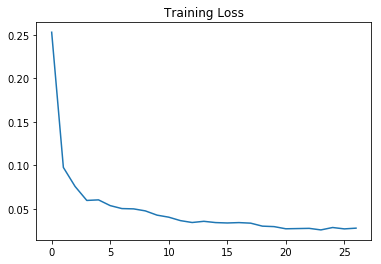

In [20]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

## Test the Trained Network

#### Test Data

In [21]:
def test(capsule_net, test_loader):
    '''Prints out test statistics for a given capsule net.
       param capsule_net: trained capsule network
       param test_loader: test dataloader
       return: returns last batch of test image data and corresponsing reconstructions
       '''
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    test_loss = 0 # loss tracking
    
    capsule_net.eval() # eval mode
    
    for batch_i, (images, target) in enumerate(test_loader):
        target = torch.eye(10).index_select(dim=0, index=target)
        
        batch_size = images.size(0)
        
        if TRAIN_ON_GPU:
            images, target = images.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, reconstructions, y = capsule_net(images)
        
        # calculate the loss
        loss = criterion(caps_output, target, images, reconstructions)
        
        # update average test loss
        test_loss += loss.item()
        
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)
        
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    # avg test loss
    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.8f}\n'.format(avg_test_loss))
    
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    # return last batch of capsule vectors, images, reconstructions
    return caps_output, images, reconstructions

In [22]:
# call test function and get reconstructed images
caps_output, images, reconstructions = test(capsule_net, test_loader)

Test Loss: 0.03309429

Test Accuracy of     0: 99% (979/980)
Test Accuracy of     1: 99% (1132/1135)
Test Accuracy of     2: 99% (1027/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 99% (889/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 99% (970/974)
Test Accuracy of     9: 98% (991/1009)

Test Accuracy (Overall): 99% (9913/10000)


#### Display the Reconstructions

In [23]:
def display_images(images, reconstructions):
    '''Plot one row of original MNIST images and another row (below) 
       of their reconstructions.'''
    
    # convert to numpy images
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, 28, 28)
    reconstructions = reconstructions.data.cpu().numpy()
    
    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, reconstructions], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

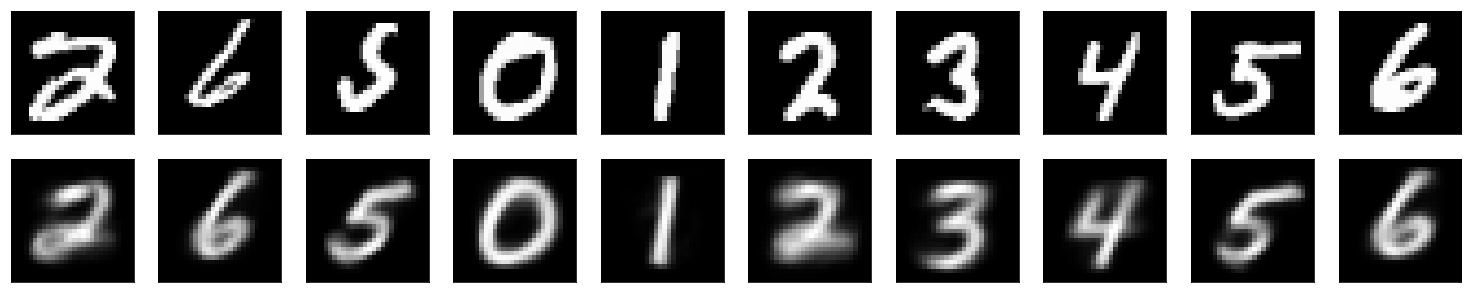

In [24]:
# display original and reconstructed images, in rows
display_images(images, reconstructions)

#### Response to Affine Transformations

In [25]:
# convert data to Tensor *and* perform random affine transformation
transform = transforms.Compose(
    [transforms.RandomAffine(degrees=30, translate=(0.1,0.1)),
     transforms.ToTensor()]
    )

# test dataset
transformed_test_data = datasets.MNIST(root='data', train=False,
                                       download=True, transform=transform)

# prepare data loader
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_data, 
                                                      batch_size=batch_size,
                                                      num_workers=num_workers)

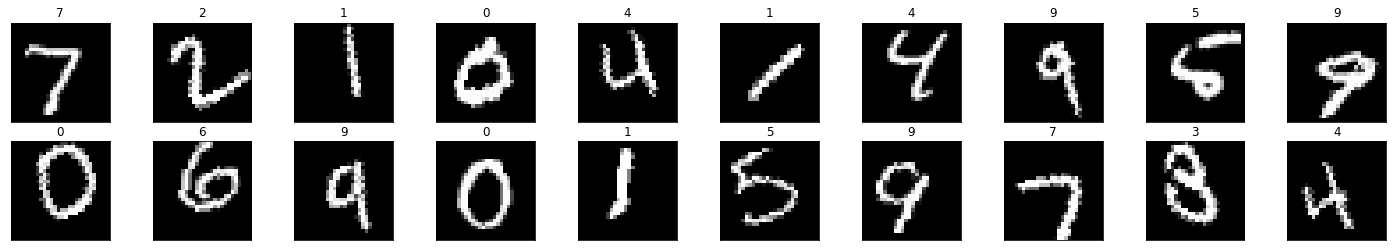

In [26]:
# obtain one batch of test images
dataiter = iter(transformed_test_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [27]:
# call test function and get reconstructed images
_, images, reconstructions = test(capsule_net, transformed_test_loader)

Test Loss: 0.28094487

Test Accuracy of     0: 90% (882/980)
Test Accuracy of     1: 90% (1022/1135)
Test Accuracy of     2: 87% (901/1032)
Test Accuracy of     3: 82% (832/1010)
Test Accuracy of     4: 79% (776/982)
Test Accuracy of     5: 91% (820/892)
Test Accuracy of     6: 77% (744/958)
Test Accuracy of     7: 77% (793/1028)
Test Accuracy of     8: 77% (756/974)
Test Accuracy of     9: 73% (737/1009)

Test Accuracy (Overall): 82% (8263/10000)


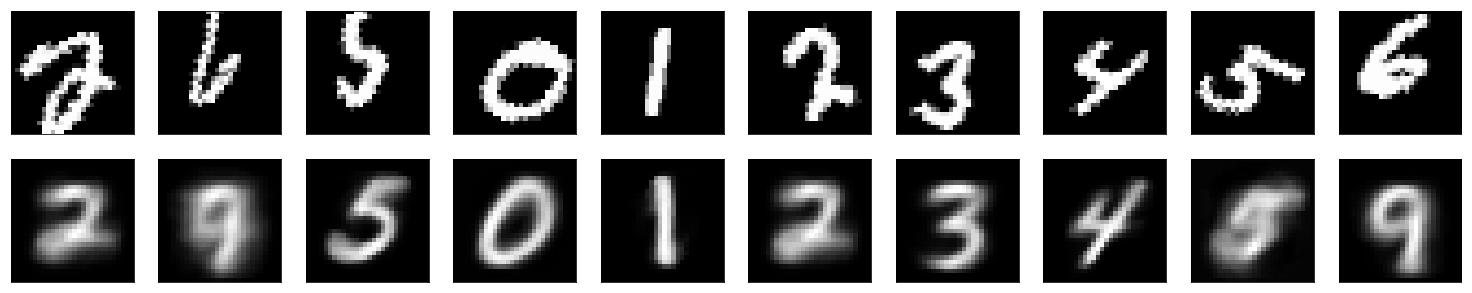

In [28]:
# original input images
display_images(images, reconstructions)

## Capsule Output Vectors (Slight Modification)

In [32]:
def vector_analysis(capsule_net, x, select_idx=1):
    '''Generates perturbed iage reconstructions given some digit capsule outputs.
       param capsule_net: trained capsule network
       param x: a batch of digit capsule outputs
       param select_idx: selects which image in a batch to analyze, default = 1 
       return: list of perturbed, reconstructed images
       '''
    
    classes = (x ** 2).sum(dim=-1) ** 0.5
    classes = F.softmax(classes, dim=-1)

    # find the capsule with the maximum vector length
    # here, vector length indicates the probability of a class' existence
    _, max_length_indices = classes.max(dim=1)

    # create a sparse class matrix
    sparse_matrix = torch.eye(10) # 10 is the number of classes
    if TRAIN_ON_GPU:
        sparse_matrix = sparse_matrix.cuda()
    # get the class scores from the "correct" capsule
    y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)

    # create reconstructed pixels
    x = x * y[:, :, None]
    
    # flatten image into a vector shape (batch_size, vector_dim)
    flattened_x = x.view(x.size(0), -1)
    # select a single image from a batch to work with
    flattened_x = flattened_x[select_idx]
    
    # track reconstructed images
    reconstructed_ims = []
    # values to change *one* vector dimension by
    perturb_range = np.arange(-0.25, 0.30, 0.05)
    
    # iterate through 16 vector dims
    for k in range(16):
        # create a copy of flattened_x to modify
        transformed_x = torch.zeros(*flattened_x.size()).cuda()
        transformed_x[:] = flattened_x[:]
        # iterate through each perturbation value
        for j in range(len(perturb_range)):
            # for each capsule output
            for i in range(10):
                transformed_x[k+(16*i)] = flattened_x[k+(16*i)]+perturb_range[j]

            # create reconstructed images
            reconstructions = capsule_net.decoder.linear_layers(transformed_x)
            
            # reshape into 28x28 image, (batch_size, depth, x, y)
            reconstructions = reconstructions.view(-1, 1, 28, 28)
            reconstructed_ims.append(reconstructions)
    
    # return final list of reconstructed ims    
    return reconstructed_ims

In [30]:
# call function and get perturbed reconstructions
reconstructed_ims = vector_analysis(capsule_net, caps_output, select_idx=1)

#### Display the Reconstructions

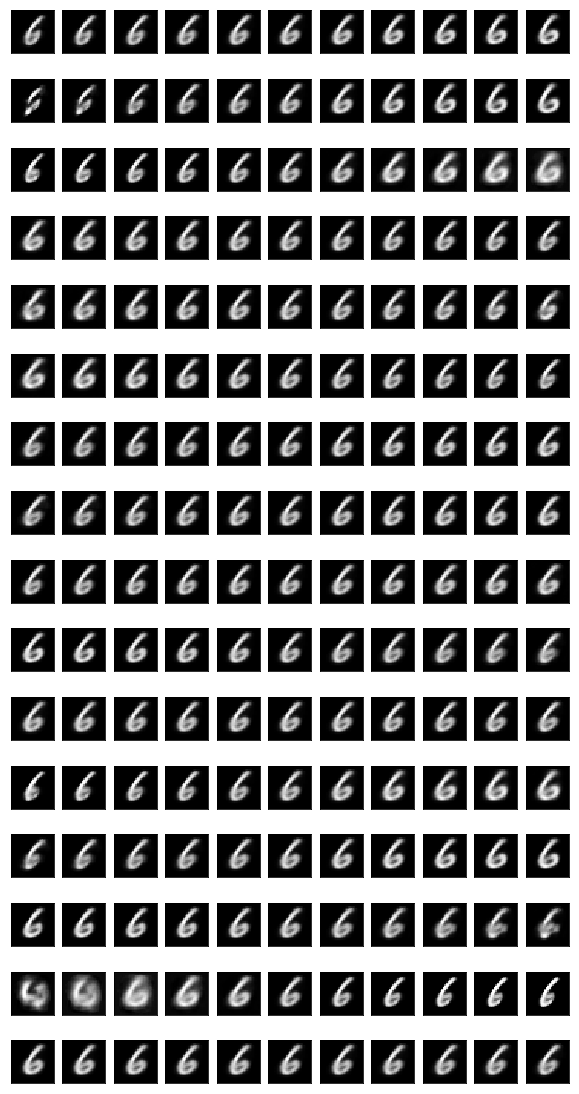

In [31]:
fig = plt.figure(figsize=(10, 20)) # define figsize

# display all ims
for idx in range(len(reconstructed_ims)):
    # convert to numpy images
    image = reconstructed_ims[idx]
    image = image.detach().cpu().numpy()
    # display 16 rows of images
    ax = fig.add_subplot(16, len(reconstructed_ims)/16, idx+1, xticks=[], yticks=[])
    ax.imshow(image.squeeze(), cmap='gray')

<hr/>